# Comparison of uniaxial loads applied on a rectangular solid with the same initial geometry and varying elastic properties

© 2023 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_solid_mechanics/blob/main/notebooks/uniaxial_load_comparison.ipynb).

> Note: Be aware that this notebook follows solid mechanics sign conventions → Tractions are positive, compressions are negative, and shear forces/stresses are positive when they act on the positive $x$-plane and point to the positive $y$-direction.

This notebook depends on:
* SolidsPy V1.0.16 [Guarín-Zapata et al. (2020)](https://doi.org/10.5281/zenodo.4029270)
* pygmsh V6.0.2 [Schlömer et al. (2019a)](https://doi.org/10.5281/zenodo.3541027)
* meshio V3.3.1 [Schlömer et al. (2019b)](https://doi.org/10.5281/zenodo.3584511)
* And other packages for general scientific programming in Python


## Setting up the environment

### Installing dependencies

In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    %pip install gmsh==4.10.5
    %pip install meshio==3.3.1
    %pip install pygmsh==6.0.2
    %pip install solidspy==1.0.16
    %pip install numpy==1.23.1
else:
    print('Not running on CoLab. Install the required modules manually in your local environment.')

Not running on CoLab. Install the required modules manually in your local environment.


### Required modules

In [2]:
import pygmsh
import meshio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import solidspy.preprocesor as pre
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol

from ipywidgets import interact, widgets, fixed

### Global configuration for plots

In [3]:
plt.style.use("default")
mpl.rcParams.update(
    {
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
        "image.cmap": 'PiYG'
    }
)


## Functions

### Creating the domain and meshing it

In [4]:
def create_domain(x=5, y=10, elem_size=1):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    '''
    # Empty structure
    geom = pygmsh.built_in.Geometry()
    # Points
    p1 = geom.add_point([0, 0, 0], elem_size)
    p2 = geom.add_point([0.5*x, 0, 0], elem_size)
    p3 = geom.add_point([0.5*x, 0.5*y, 0], elem_size)
    p4 = geom.add_point([0, 0.5*y, 0], elem_size)
    # Lines
    l1 = geom.add_line(p1, p2)  # Bottom line
    l2 = geom.add_line(p2, p3)  # Rigth line
    l3 = geom.add_line(p3, p4)  # Upper line
    l4 = geom.add_line(p4, p1)  # Left line
    # Surfaces
    ll1 = geom.add_line_loop([l1, l2, l3, l4])
    s1 = geom.add_plane_surface(ll1)
    # Physical groups
    geom.add_physical(s1, label="100")  # Material
    geom.add_physical(l3, label="load_line")  # Upper boundary (load line)
    geom.add_physical(l1, label="400")  # Lower boundary
    return pygmsh.generate_mesh(
        geom, geo_filename="mesh.geo", msh_filename="mesh.msh"
    )

def plot_mesh(nodes, elements, loads):
    tri_mesh = pos.mesh2tri(nodes, elements)
    plt.triplot(
        tri_mesh, marker=".", lw=0.5, ms=2, color="b")
    for i in range(len(loads)):
        load = nodes[int(loads[i, 0])]
        if loads[i, -1] < 0:
            plt.arrow(x=load[1], y=load[2]+.5, dx=0, dy=-.5, width=.03,  fc='k',
                    ec='k', head_width=.17, length_includes_head=True)
        elif loads[i, -1] > 0:
            plt.arrow(x=load[1], y=load[2], dx=0, dy=.5, width=.03,  fc='k',
                    ec='k', head_width=.17, length_includes_head=True)
        if loads[i, 1] < 0:
            plt.arrow(x=load[1], y=load[2], dx=-.5, dy=0, width=.03,  fc='k',
                    ec='k', head_width=.17, length_includes_head=True)
        elif loads[i, 1] > 0:
            plt.arrow(x=load[1]-.5, y=load[2], dx=.5, dy=0, width=.03,  fc='k',
                    ec='k', head_width=.17, length_includes_head=True)
    # Restricciones
    x, y = nodes[:, 1:3].T
    bcx = nodes[:, 3] == -1
    bcy = nodes[:, 4] == -1
    ms=5
    plt.plot(x[bcx]-ms/100, y[bcx], "ok", ms=ms, fillstyle='none')
    plt.plot(x[bcy], y[bcy]-ms/100, "ok", ms=ms, fillstyle='none')
    # plt.plot(x[bcx], y[bcx], "xk", label="$x$-restrained")
    # plt.plot(x[bcy], y[bcy], "+k", label="$y$-restrained")
    # Format
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axis("image")
    plt.xlabel('$x$  [m]')
    plt.ylabel('$y$  [m]')
    return

def plot_def_undef_mesh(nodes_def, nodes_undef, elements, **kwargs):
    tri_mesh = pos.mesh2tri(nodes_def, elements)
    plt.triplot(
        tri_mesh, marker=".", lw=0.7, ms=2, color="r", label='Deformed mesh')
    tri_mesh = pos.mesh2tri(nodes_undef, elements)
    plt.triplot(
        tri_mesh, marker=".", lw=0.5, ms=1.5, color="b", label='Undeformed mesh')
    # Restricciones
    x, y = nodes_undef[:, 1:3].T
    bcx = nodes_undef[:, 3] == -1
    bcy = nodes_undef[:, 4] == -1
    ms=5
    plt.plot(x[bcx]-ms/100, y[bcx], "ok", ms=ms, fillstyle='none')
    plt.plot(x[bcy], y[bcy]-ms/100, "ok", ms=ms, fillstyle='none')
    # Format
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=kwargs.get('title'))
    plt.axis("image")
    plt.xlabel('$x$  [m]')
    plt.ylabel('$y$  [m]')
    return

def mesh2tri(nodes, elements, field):
    coord_x = nodes[:, 1]
    coord_y = nodes[:, 2]
    triangs = [elem[3:] for elem in elements]
    mask = np.any(np.isinf(field[triangs]), axis=1)
    mask += np.any(np.isnan(field[triangs]), axis=1)
    tri = mpl.tri.Triangulation(coord_x, coord_y, np.array(triangs), mask)
    return tri

def plot_fields(
        fields, nodes, elements, titles, share_colorbar=True, cmap="RdYlBu",
         plot_eigenvalues=False, **kwargs):
    fig, axs = plt.subplots(
        ncols=len(fields), nrows=1, figsize=[4.2*len(fields), 4], sharey=True)
    if len(fields) == 1:
        axs = list(axs)
    levels = 16
    if share_colorbar:
        vmin = min(np.nanmin(field[np.isfinite(field)]) for field in fields)
        vmax = max(np.nanmax(field[np.isfinite(field)]) for field in fields)
        locator = MaxNLocator(nbins=levels, prune='both')
        levels = locator.tick_values(vmin, vmax)
    else: 
        vmin, vmax = None, None
    for ax, field, title, i in zip(axs, fields, titles, range(len(fields))):
        tri_mesh = mesh2tri(nodes, elements, field)
        im = ax.tricontourf(
            tri_mesh, field, levels=levels, vmin=vmin, vmax=vmax,
            cmap=cmap, extend='both')
        ax.axis('image')
        ax.set_title(title)
        ax.set_xlabel('$x$  [m]')
        if plot_eigenvalues:
            plot_eigenval(kwargs['complete_tensors'][i], nodes, elements, ax)
        if not share_colorbar:
            fig.colorbar(im, ax=ax, shrink=.7, pad=0.01)
    axs[0].set_ylabel('$y$  [m]')
    if share_colorbar:
        fig.colorbar(im, ax=axs, shrink=.7, pad=0.01)
    return

def plot_eigenval(tensors, nodes, elements, ax):
    # Create the grid
    xx = np.linspace(nodes[:, 1].min(), nodes[:, 1].max(), 50)
    yy = np.linspace(nodes[:, 2].min(), nodes[:, 2].max(), 50)
    x_grid, y_grid = np.meshgrid(xx, yy)
    x_grid, y_grid
    # Interpolate values at regular grid and flatten them
    sigma_x = get_a_value(x_grid, y_grid, tensors["𝜎_xx"], nodes, elements).flatten()
    sigma_y = get_a_value(x_grid, y_grid, tensors["𝜎_yy"], nodes, elements).flatten()
    tau_xy = get_a_value(x_grid, y_grid, tensors["𝜏_xy"], nodes, elements).flatten()
    # Obtain principal directions from tensors, rearrange them properly
    sigma_1, sigma_3, eigvec_1, eigvec_3 = pos.principal_dirs(
            np.array([sigma_x, sigma_y, tau_xy]).T)
    sigma_1 = sigma_1.reshape(-1, len(xx))
    sigma_3 = sigma_3.reshape(-1, len(xx))
    eigvec_1_x = eigvec_1[:, 0].reshape(-1, len(xx))
    eigvec_1_y = eigvec_1[:, 1].reshape(-1, len(xx))
    eigvec_3_x = eigvec_3[:, 0].reshape(-1, len(xx))
    eigvec_3_y = eigvec_3[:, 1].reshape(-1, len(xx))
    # Update axix
    ax.streamplot(x=xx, y=yy, u=eigvec_1_x, v=eigvec_1_y, color='k', linewidth=0.2, arrowstyle='-')
    ax.streamplot(x=xx, y=yy, u=eigvec_3_x, v=eigvec_3_y, color='k',  linewidth=0.2, arrowstyle='-')


#### Creating solidspy inputs

In [43]:
def create_loads_array(mesh, load_x, load_y):
    load_line_id = mesh.field_data['load_line'][0]
    physical_line_nodes = mesh.cells["line"]
    physical_line_id = mesh.cell_data["line"]["gmsh:physical"]
    nodes_carga = np.unique(
        physical_line_nodes[physical_line_id==load_line_id].flatten())
    weights = np.array(
        [0.5 if mesh.points[node, 0] in [0, 0.5 * domain_width] else 1 for node in nodes_carga])
    nloads = len(nodes_carga)
    loads_array = np.zeros((nloads, 3))
    loads_array[:, 0] = nodes_carga
    # loads_array[:, 1] = load_x/nloads
    # loads_array[:, 2] = load_y/nloads
    loads_array[:, 1] = load_x * weights / np.sum(weights)
    loads_array[:, 2] = load_y * weights / np.sum(weights)
    return loads_array

def solidspy_inputs(mesh, elastic_mod, poisson_rat, load_x, load_y):
    """Parameters in the International System of Units.
    - Lengths in [m]
    - Loads (forces) in [N/m]
    """
    # points = mesh.points
    # cells = mesh.cells
    point_data = mesh.point_data
    cell_data = mesh.cell_data
    field_data = mesh.field_data
    # Elements data
    eles_array = np.zeros([len(mesh.cells['triangle']), 6], dtype=int)
    eles_array[:, 0] = range(len(mesh.cells['triangle']))  # Element identifier
    eles_array[:, 1] = 3  # Element type (3 for a 3-noded triangle)
    eles_array[:, 3:] = mesh.cells['triangle']  # Element connectivity
    # Nodes
    nodes_array = np.zeros([len(mesh.points), 5])
    nodes_array[:, 0] = range(len(mesh.points))  # Nodal identifier
    nodes_array[:, 1:3] = mesh.points[:, :2]  # x-y coordinates (columns 1-2)
    # Boundaries
    nodes_array[:, 3][nodes_array[:, 1] == 0] = -1  # restriction in x-dir
    nodes_array[:, 4][nodes_array[:, 2] == 0] = -1  # restriction in x-dir
    # Loads
    loads_array = create_loads_array(mesh, 0.5*load_x, 0.5*load_y)
    #  Material
    mats_array = np.array([[elastic_mod, poisson_rat]])
    return (nodes_array, mats_array, eles_array, loads_array)


#### Executing the solver

In [44]:
def run_solidspy(nodes, mats, elements, loads):
    """Parameters in the International System of Units.
    - Lengths in [m]
    - Stress in [kPa]
    """
    # System assembly
    assem_op, bc_array, neq = ass.DME(nodes, elements)
    stiff_mat = ass.assembler(elements, mats, nodes, neq, assem_op)
    rhs_vec = ass.loadasem(loads, bc_array, neq)
    # System solution
    disp = sol.static_sol(stiff_mat, rhs_vec)
    # Post-processing
    # Fill the displacement vectors with imposed and computed values
    disp = pos.complete_disp(bc_array, nodes, disp)
    # Averaged strains and stresses at nodes
    strain, stress = pos.strain_nodes(nodes, elements, mats, disp)
    # Compute the principal directions of a tensor field
    eigs1, eigs3, eigvec_1, eigvec_3 = pos.principal_dirs(stress)
    tensors = {
        "𝜎_1": 1e-3 * eigs1,
        "𝜎_2": np.full_like(eigs1, np.nan),
        "𝜎_3": 1e-3 * eigs3,
        "𝜎_xx": 1e-3 * stress[:, 0],
        "𝜎_yy": 1e-3 * stress[:, 1],
        "𝜏_xy": 1e-3 * stress[:, 2],
        "𝜀_xx": strain[:, 0],
        "𝜀_yy": strain[:, 1],
        "𝛾_xy": strain[:, 2],
        "𝜐_x": disp[:, 0],
        "𝜐_y": disp[:, 1],
    }
    return tensors, eigvec_1, eigvec_3


## Running the cases

In [67]:
# GLOBAL INPUTS
load = 1e7  # [N/m]
elastic_mod = 50e6  # [N/m²]
domain_width = 10  # [m]
domain_depth = 20  # [m]

# Creating the domain and meshing it for solving through FEM
mesh = create_domain(x=domain_width, y=domain_depth, elem_size=0.5)#*domain_width/4)

Info    : Running '/home/eamontoyaa/.pyenv/versions/3.9.13/envs/solidspy-env/bin/gmsh -3 mesh.geo -format msh -bin -o mesh.msh' [Gmsh 4.10.5, 1 node, max. 1 thread]
Info    : Started on Tue Mar 28 18:41:34 2023
Info    : Reading 'mesh.geo'...
Info    : Done reading 'mesh.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000368342s, CPU 0.001388s)
Info    : Meshing 2D...
Info    : Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00774449s, CPU 0.030151s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.8932e-05s, CPU 0s)
Info    : 274 nodes 550 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'
Info    : Stopped on Tue Mar 28 18:41:34 2023 (From start: Wall 0.0332244s, CPU 0.539562s)

msh file: mesh.msh

geo file: mesh.geo


In [68]:
# CASE 1: Compression, 𝜇>0
# ------------------------
load_case_1 = -1 * load
𝜇 = 0.3
# Creating solidspy inputs
nodes_case_1, mats_case_1, elements_case_1, loads_case_1 = solidspy_inputs(mesh, elastic_mod, 𝜇, load_x=0, load_y=load_case_1)
# loads_case_1[:, -1] *= weights#/np.sum(weights)
tensors_case_1, eigvec_1_case_1, eigvec_3_case_1 = run_solidspy(nodes_case_1, mats_case_1, elements_case_1, loads_case_1)

# CASE 2: Compression, 𝜇=0
# ------------------------
load_case_2 = -1 * load
𝜇 = 0.0
# Creating solidspy inputs
nodes_case_2, mats_case_2, elements_case_2, loads_case_2 = solidspy_inputs(mesh, elastic_mod, 𝜇, load_x=0, load_y=load_case_2)
# loads_case_2[:, -1] *= weights#/np.sum(weights)
tensors_case_2, eigvec_1_case_2, eigvec_3_case_2 = run_solidspy(nodes_case_2, mats_case_2, elements_case_2, loads_case_2)

# CASE 3: Traction, 𝜇=0
# ------------------------
load_case_3 = load
𝜇 = 0.0
# Creating solidspy inputs
nodes_case_3, mats_case_3, elements_case_3, loads_case_3 = solidspy_inputs(mesh, elastic_mod, 𝜇, load_x=0, load_y=load_case_3)
# loads_case_3[:, -1] *= weights#/np.sum(weights)
tensors_case_3, eigvec_1_case_3, eigvec_3_case_3 = run_solidspy(nodes_case_3, mats_case_3, elements_case_3, loads_case_3)


## Plotting results

### Mesh

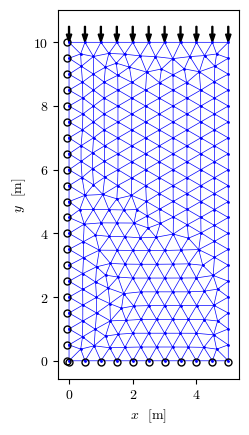

In [69]:
plot_mesh(nodes_case_1, elements_case_1, loads_case_1)

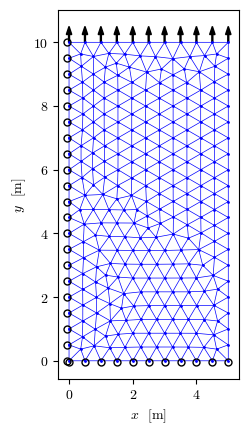

In [70]:
plot_mesh(nodes_case_3, elements_case_1, loads_case_3)

### Cartesian stresses

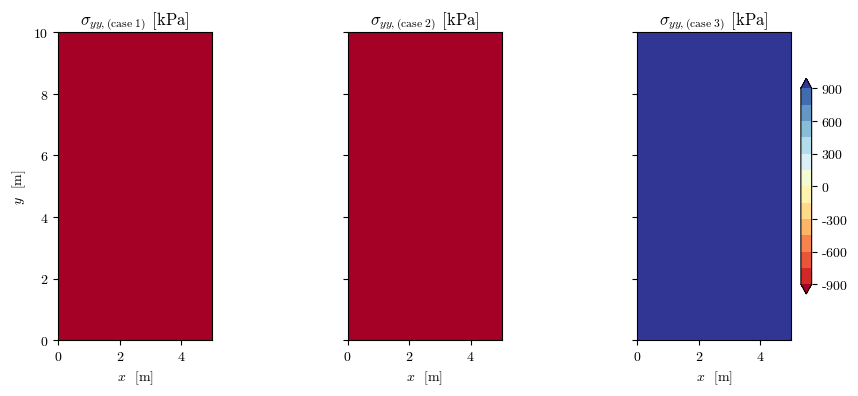

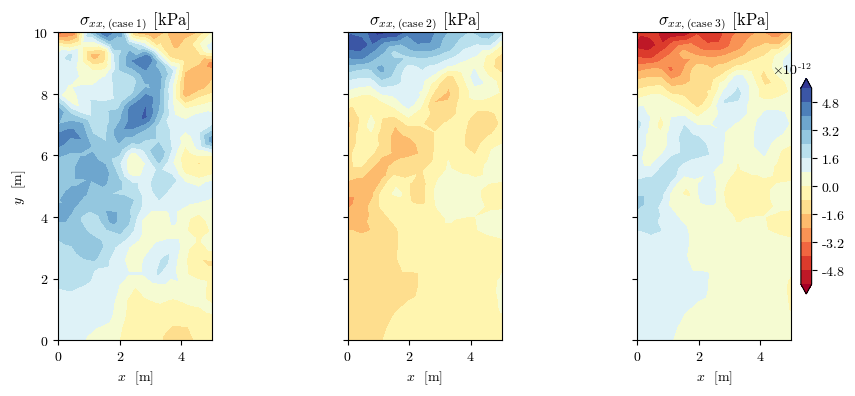

In [81]:
plot_fields(
    fields=(tensors_case_1["𝜎_yy"], tensors_case_2["𝜎_yy"], tensors_case_3["𝜎_yy"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$\sigma_{yy, \mathrm{(case\ 1)}}$ [kPa]",
            "$\sigma_{yy, \mathrm{(case\ 2)}}$ [kPa]",
            "$\sigma_{yy, \mathrm{(case\ 3)}}$ [kPa]"],
    share_colorbar=True
)
plot_fields(
    fields=(tensors_case_1["𝜎_xx"], tensors_case_2["𝜎_xx"], tensors_case_3["𝜎_xx"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$\sigma_{xx, \mathrm{(case\ 1)}}$ [kPa]",
            "$\sigma_{xx, \mathrm{(case\ 2)}}$ [kPa]",
            "$\sigma_{xx, \mathrm{(case\ 3)}}$ [kPa]"],
    share_colorbar=True
)

### Principal stresses and directions

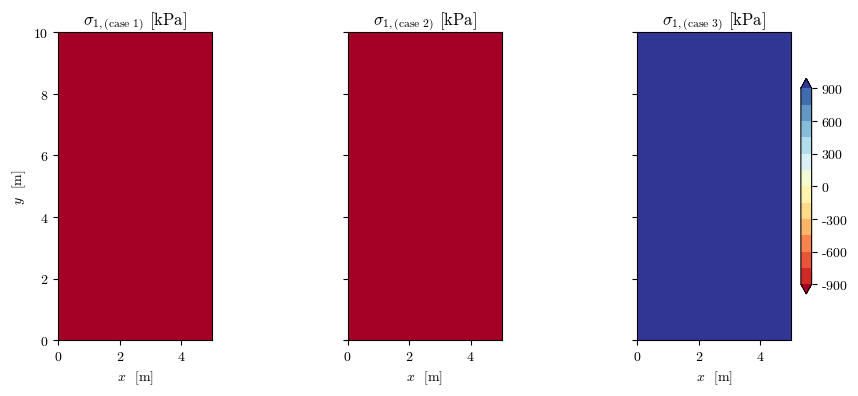

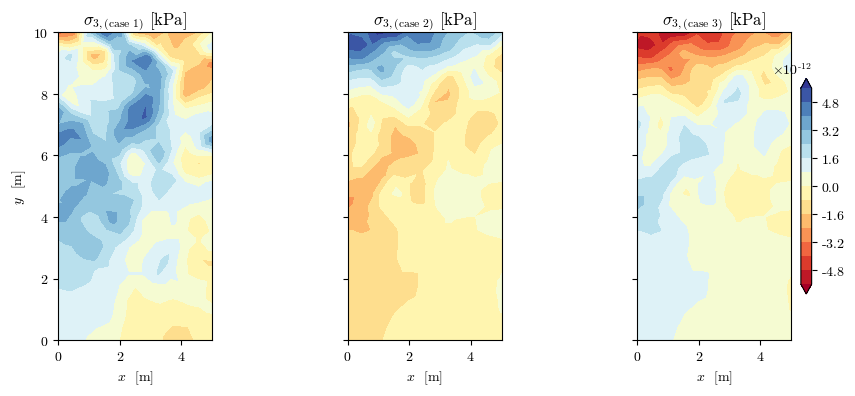

In [80]:
# Major principal stress
plot_fields(
    fields=(tensors_case_1["𝜎_1"], tensors_case_2["𝜎_1"], tensors_case_3["𝜎_1"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$\sigma_{1, \mathrm{(case\ 1)}}$ [kPa]",
            "$\sigma_{1, \mathrm{(case\ 2)}}$ [kPa]",
            "$\sigma_{1, \mathrm{(case\ 3)}}$ [kPa]"],
    share_colorbar=True
)
# Minor principal stress
plot_fields(
    fields=(tensors_case_1["𝜎_3"], tensors_case_2["𝜎_3"], tensors_case_3["𝜎_3"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$\sigma_{3, \mathrm{(case\ 1)}}$ [kPa]",
            "$\sigma_{3, \mathrm{(case\ 2)}}$ [kPa]",
            "$\sigma_{3, \mathrm{(case\ 3)}}$ [kPa]"],
    share_colorbar=True
)

### Displacements

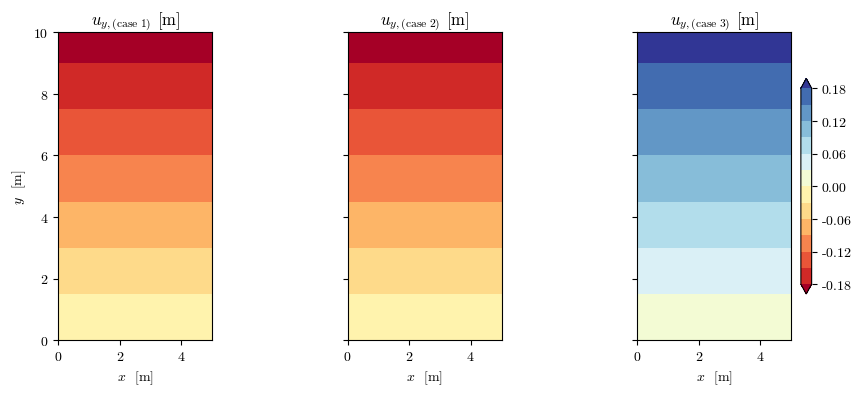

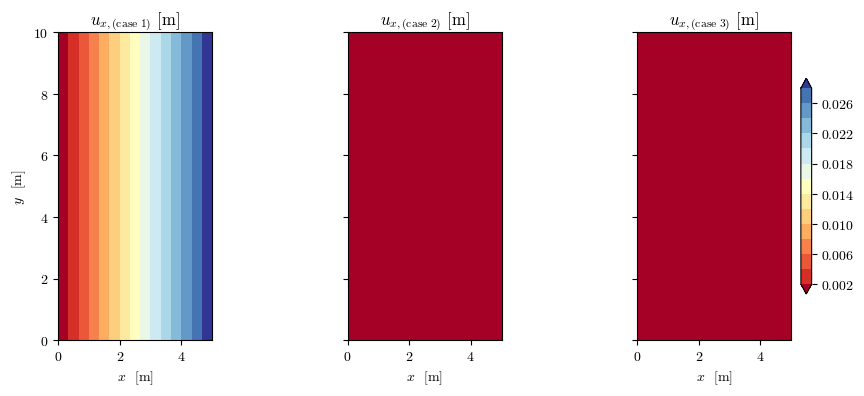

In [79]:
# Displacements in y-direction
plot_fields(
    fields=(tensors_case_1["𝜐_y"], tensors_case_2["𝜐_y"], tensors_case_3["𝜐_y"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$u_{y, \mathrm{(case\ 1)}}$ [m]",
            "$u_{y, \mathrm{(case\ 2)}}$ [m]",
            "$u_{y, \mathrm{(case\ 3)}}$ [m]"],
    share_colorbar=True
)
# Displacements in x-direction
plot_fields(
    fields=(tensors_case_1["𝜐_x"], tensors_case_2["𝜐_x"], tensors_case_3["𝜐_x"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$u_{x, \mathrm{(case\ 1)}}$ [m]",
            "$u_{x, \mathrm{(case\ 2)}}$ [m]",
            "$u_{x, \mathrm{(case\ 3)}}$ [m]"],
    share_colorbar=True
)

### Mesh visualization with displacements

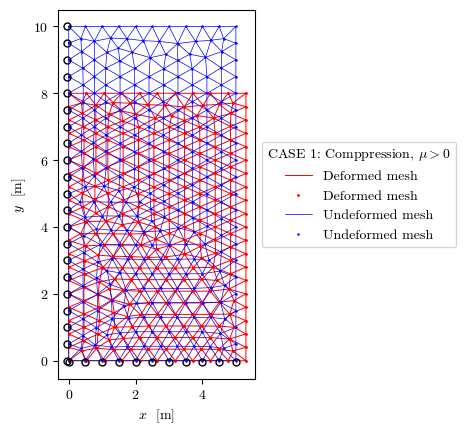

In [74]:
# CASE 1
factor = 10
nodes_case_1_def = nodes_case_1.copy()
nodes_case_1_def[:, 1] += factor*tensors_case_1["𝜐_x"]
nodes_case_1_def[:, 2] += factor*tensors_case_1["𝜐_y"]
plot_def_undef_mesh(
    nodes_case_1_def, nodes_case_1, elements_case_1,
    title='CASE 1: Comppression, $\mu>0$')

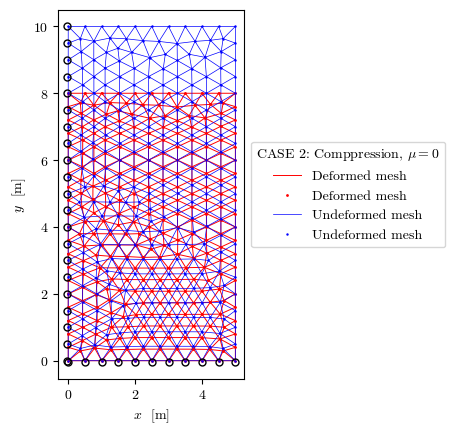

In [75]:
# CASE 2
factor = 10
nodes_case_2_def = nodes_case_2.copy()
nodes_case_2_def[:, 1] += factor*tensors_case_2["𝜐_x"]
nodes_case_2_def[:, 2] += factor*tensors_case_2["𝜐_y"]
plot_def_undef_mesh(
    nodes_case_2_def, nodes_case_2, elements_case_2, 
    title='CASE 2: Comppression, $\mu=0$')

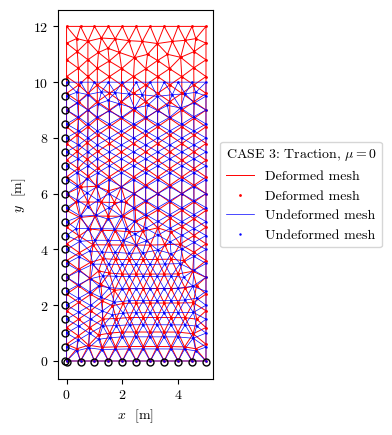

In [76]:
# CASE 3
factor = 10
nodes_case_3_def = nodes_case_3.copy()
nodes_case_3_def[:, 1] += factor*tensors_case_3["𝜐_x"]
nodes_case_3_def[:, 2] += factor*tensors_case_3["𝜐_y"]
plot_def_undef_mesh(
    nodes_case_3_def, nodes_case_3, elements_case_3,
    title='CASE 3: Traction, $\mu=0$')

### Strains

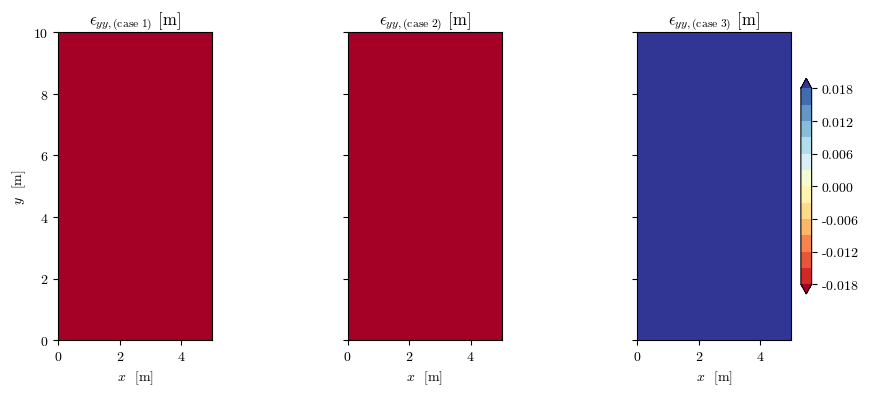

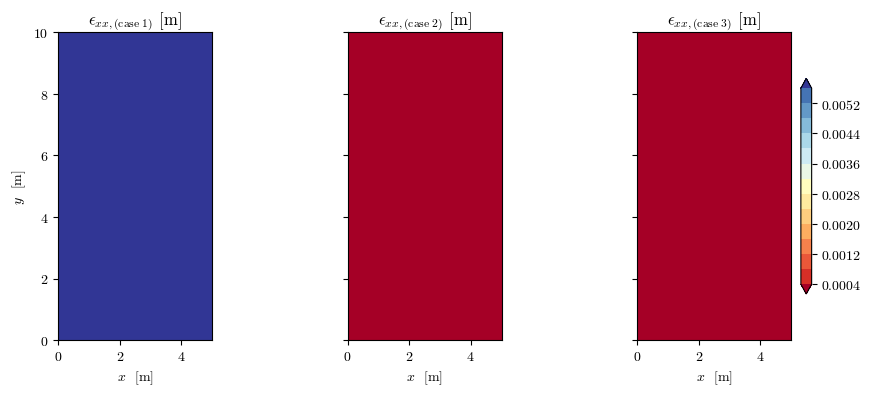

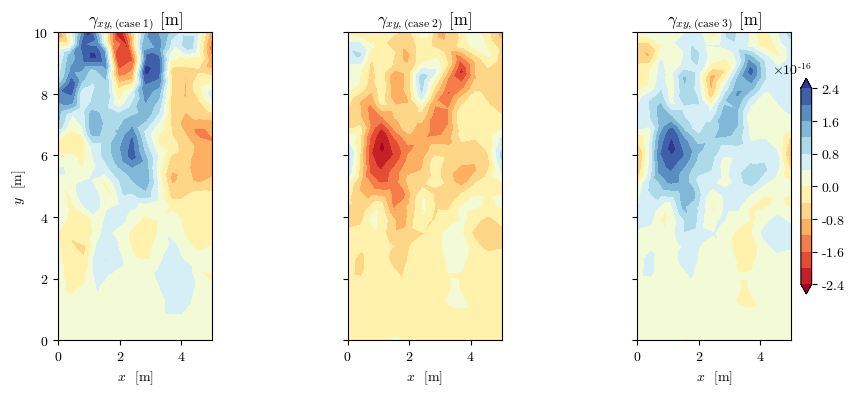

In [78]:
# Strain in y-direction
plot_fields(
    fields=(tensors_case_1["𝜀_yy"], tensors_case_2["𝜀_yy"], tensors_case_3["𝜀_yy"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$\epsilon_{yy, \mathrm{(case\ 1)}}$ [m]",
            "$\epsilon_{yy, \mathrm{(case\ 2)}}$ [m]",
            "$\epsilon_{yy, \mathrm{(case\ 3)}}$ [m]"],
    share_colorbar=True
)
# Strain in x-direction
plot_fields(
    fields=(tensors_case_1["𝜀_xx"], tensors_case_2["𝜀_xx"], tensors_case_3["𝜀_xx"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$\epsilon_{xx, \mathrm{(case\ 1)}}$ [m]",
            "$\epsilon_{xx, \mathrm{(case\ 2)}}$ [m]",
            "$\epsilon_{xx, \mathrm{(case\ 3)}}$ [m]"],
    share_colorbar=True
)
# Shear strain
plot_fields(
    fields=(tensors_case_1["𝛾_xy"], tensors_case_2["𝛾_xy"], tensors_case_3["𝛾_xy"]),
    nodes=nodes_case_1, elements=elements_case_1,
    titles=["$\gamma_{xy, \mathrm{(case\ 1)}}$ [m]",
            "$\gamma_{xy, \mathrm{(case\ 2)}}$ [m]",
            "$\gamma_{xy, \mathrm{(case\ 3)}}$ [m]"],
    share_colorbar=True
)